In [1]:
from qiskit import QuantumCircuit, transpile, qasm3
from math import pi

In [2]:
NUM_QUBITS = 5
NUM_LAYERS = 1
SHOTS = 1000

In [ ]:
def add_permutions(qc: QuantumCircuit):
    for i in range(qc.num_qubits):
        angle = pi * (i / (qc.num_qubits - 1))
        qc.u(angle, angle, angle, i)


def add_entanglements(qc: QuantumCircuit, cx: bool = False, u: bool = True):
    for i in range(qc.num_qubits):
        if cx:
            qc.cx(i, (i + 1) % qc.num_qubits)
        if u:
            angle = pi * ((qc.num_qubits - 1 - i) / (qc.num_qubits - 1))
            qc.cu(angle, angle, angle, 0, i, (i + 1) % qc.num_qubits)


def add_inverse(qc: QuantumCircuit):
    qc &= qc.inverse()


def generate_permuted_mirror_circuit(
    num_qubits: int, num_layers: int
) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    for _ in range(num_layers):
        add_permutions(qc)
        add_entanglements(qc)
        add_inverse(qc)
    return qc

Result (optimal=5): 5 * 892 / 1000 = 4.46


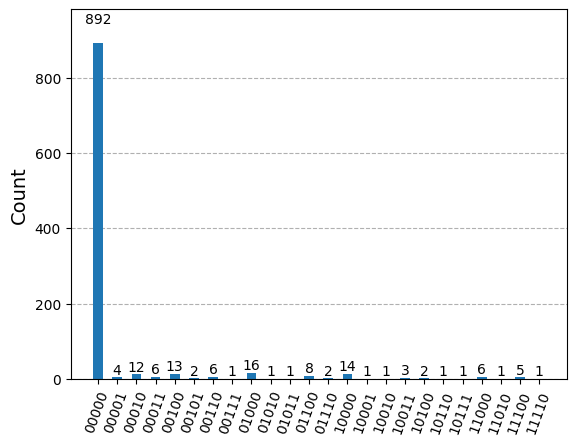

In [ ]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram

backend = GenericBackendV2(qc.num_qubits)
t_qc = transpile(
    circuits=qc, backend=backend, optimization_level=0
)  # prevent benchmark being optimized away
t_qc.measure_all()

counts = backend.run(run_input=t_qc, shots=SHOTS).result().get_counts()
result = qc.num_qubits * counts.get("0" * len(set(counts.keys()).pop()), 0) / SHOTS

print(
    f"Result (optimal={qc.num_qubits}): {qc.num_qubits} * {counts.get("0" * len(set(counts.keys()).pop()), 0)} / {SHOTS} = {result}"
)

plot_histogram(counts)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

NUM_QUBITS = 156
NUM_LAYERS = 1
SHOTS = 10000

qc = generate_permuted_mirror_circuit(num_qubits=NUM_QUBITS, num_layers=NUM_LAYERS)
qc.measure_all()

# Load your IBMQ account
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_fez")

# Transpile the circuit for the backend
t_qc = transpile(qc, backend=backend, optimization_level=0)

# Execute the circuit on the ibm_fez backend
job = backend.run(t_qc, shots=SHOTS)
print("Job ID:", job.job_id())

# Monitor the job status (optional)
job.queue_position()

# Get the results
result = job.result()
counts = result.get_counts()

# Calculate the result
result = qc.num_qubits * counts.get("0" * len(set(counts.keys()).pop()), 0) / SHOTS
print(
    f"Result (optimal={qc.num_qubits}): {qc.num_qubits} * {counts.get('0' * len(set(counts.keys()).pop()), 0)} / {SHOTS} = {result}"
)

In [ ]:
from qiskit_ionq import IonQProvider

NUM_QUBITS = 25
NUM_LAYERS = 1
SHOTS = 10000

qc = generate_permuted_mirror_circuit(num_qubits=NUM_QUBITS, num_layers=NUM_LAYERS)
qc.measure_all()

# Load your IBMQ account
provider = IonQProvider()
backend = provider.get_backend("qpu.aria-1", gateset="native")

# Transpile the circuit for the backend
t_qc = transpile(qc, backend=backend, optimization_level=0)

# Execute the circuit on the ibm_fez backend
job = backend.run(t_qc, shots=SHOTS)
print("Job ID:", job.job_id())

# Monitor the job status (optional)
# job.queue_position()

# Get the results
result = job.result()
counts = result.get_counts()

# Calculate the final result
result = qc.num_qubits * counts.get("0" * len(set(counts.keys()).pop()), 0) / SHOTS
print(
    f"Result (optimal={qc.num_qubits}): {qc.num_qubits} * {counts.get('0' * len(set(counts.keys()).pop()), 0)} / {SHOTS} = {result}"
)

In [ ]:
import json

ibm_zeros = 0
ibm_results = []
with open("data/ibm_fez.json") as f:
    data = json.load(f)
    for result, count in data["results"][0]["data"]["counts"].items():
        bin_str = bin(int(result, 16))[2:].zfill(
            data["results"][0]["header"]["n_qubits"]
        )
        ibm_results.append((bin_str, count))
        ibm_zeros += count * bin_str.count("0")

print(ibm_zeros / 10000)

100.8969


In [7]:
import json

ionq_zeros = 0
ionq_results = []
with open("data/ionq_aria-1.json") as f:
    counts = json.load(f)
    for result, count in counts.items():
        bin_str = bin(int(result))[2:].zfill(25)
        ionq_results.append((bin_str, round(count * 10000)))
        ionq_zeros += count * bin_str.count("0")
print(ionq_zeros)

20.915099999999153


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Compute Zero-State Probability
def compute_zero_probability(zeros, shots):
    return zeros / shots


# Compute Average Hamming Distance
def compute_hamming_distance(results, num_qubits):
    total_hd = 0
    total_counts = 0
    for bitstring, count in results:
        hd = sum(int(b) for b in bitstring)  # Count '1's in the bitstring
        total_hd += hd * count
        total_counts += count
    return total_hd / total_counts


# Compute Error per Qubit
def compute_error_per_qubit(results, num_qubits):
    error_counts = [0] * num_qubits
    total_counts = 0
    for bitstring, count in results:
        for i, bit in enumerate(bitstring):
            if bit == "1":
                error_counts[i] += count
        total_counts += count
    return [e / total_counts for e in error_counts]


# Visualize Bitstring Distribution
def plot_bitstring_distribution(results, title):
    bitstrings = [b for b, _ in results]
    counts = [c for _, c in results]
    plt.bar(bitstrings, counts)
    plt.title(title)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Visualize Error per Qubit
def plot_error_per_qubit(errors, title):
    plt.bar(range(len(errors)), errors)
    plt.title(title)
    plt.xlabel("Qubit Index")
    plt.ylabel("Error Rate")
    plt.tight_layout()
    plt.show()


# Compute Correlation Between Qubits
def compute_qubit_correlation(results, num_qubits):
    correlations = np.zeros((num_qubits, num_qubits))
    total_counts = 0
    for bitstring, count in tqdm(results):
        for i in range(num_qubits):
            for j in range(num_qubits):
                correlations[i, j] += int(bitstring[i]) * int(bitstring[j]) * count
        total_counts += count
    return correlations / total_counts


# Visualize Qubit Correlation as Heatmap
def plot_qubit_correlation(correlations, title):
    plt.imshow(correlations, cmap="hot", interpolation="nearest")
    plt.colorbar(label="Correlation")
    plt.title(title)
    plt.xlabel("Qubit Index")
    plt.ylabel("Qubit Index")
    plt.tight_layout()
    plt.show()


# Compute Entropy of Distribution
def compute_entropy(results):
    total_counts = sum(c for _, c in results)
    probabilities = [c / total_counts for _, c in results]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)


# Scaling Analysis: Compare Normalized Metrics
def normalize_metric(metric, scale_factor):
    return metric / scale_factor


# Visualization for Scaling
def plot_scaling(x_values, y_values, title, xlabel, ylabel):
    plt.plot(x_values, y_values, marker="o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [ ]:
ibm_zero_prob = compute_zero_probability(ibm_zeros, 10000)
ionq_zero_prob = compute_zero_probability(
    ionq_zeros, 1
)  # IonQ results are already scaled
print(f"IBM Zero Probability: {ibm_zero_prob}")
print(f"IonQ Zero Probability: {ionq_zero_prob}")

IBM Zero Probability: 100.8969
IonQ Zero Probability: 20.915099999999153


In [10]:
ibm_hd = compute_hamming_distance(ibm_results, 156)
ionq_hd = compute_hamming_distance(ionq_results, 25)
print(f"IBM Hamming Distance: {ibm_hd}")
print(f"IonQ Hamming Distance: {ionq_hd}")

IBM Hamming Distance: 55.1031
IonQ Hamming Distance: 4.0849


IBM Average Error per Qubit: 0.353225
IonQ Average Error per Qubit: 0.163396


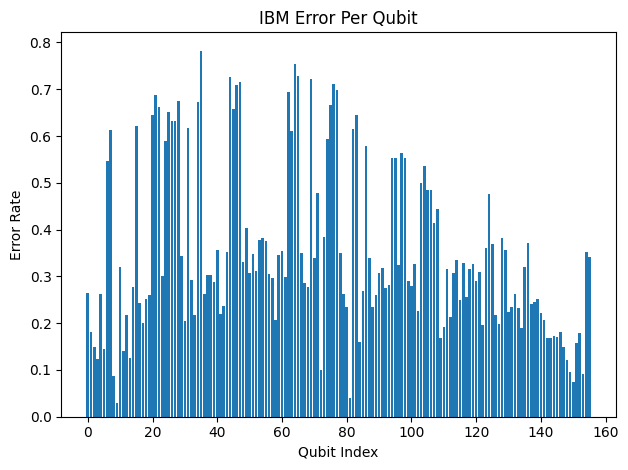

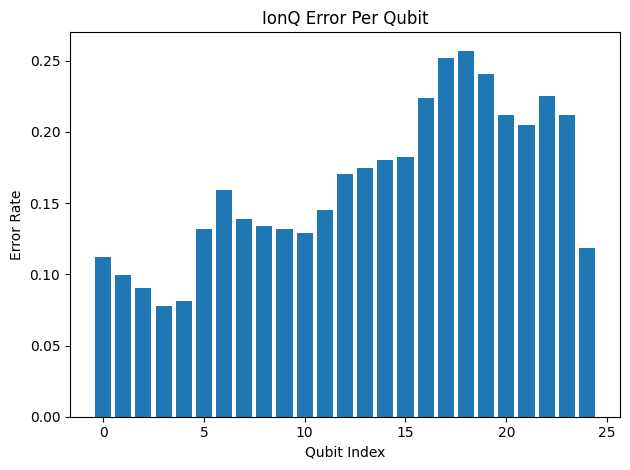

In [11]:
ibm_errors = compute_error_per_qubit(ibm_results, 156)
ionq_errors = compute_error_per_qubit(ionq_results, 25)
print(f"IBM Average Error per Qubit: {np.mean(ibm_errors)}")
print(f"IonQ Average Error per Qubit: {np.mean(ionq_errors)}")
plot_error_per_qubit(ibm_errors, "IBM Error Per Qubit")
plot_error_per_qubit(ionq_errors, "IonQ Error Per Qubit")

/var/folders/hm/dtw32z5s68q63k99phl02ytw0000gn/T/ipykernel_40013/458581111.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


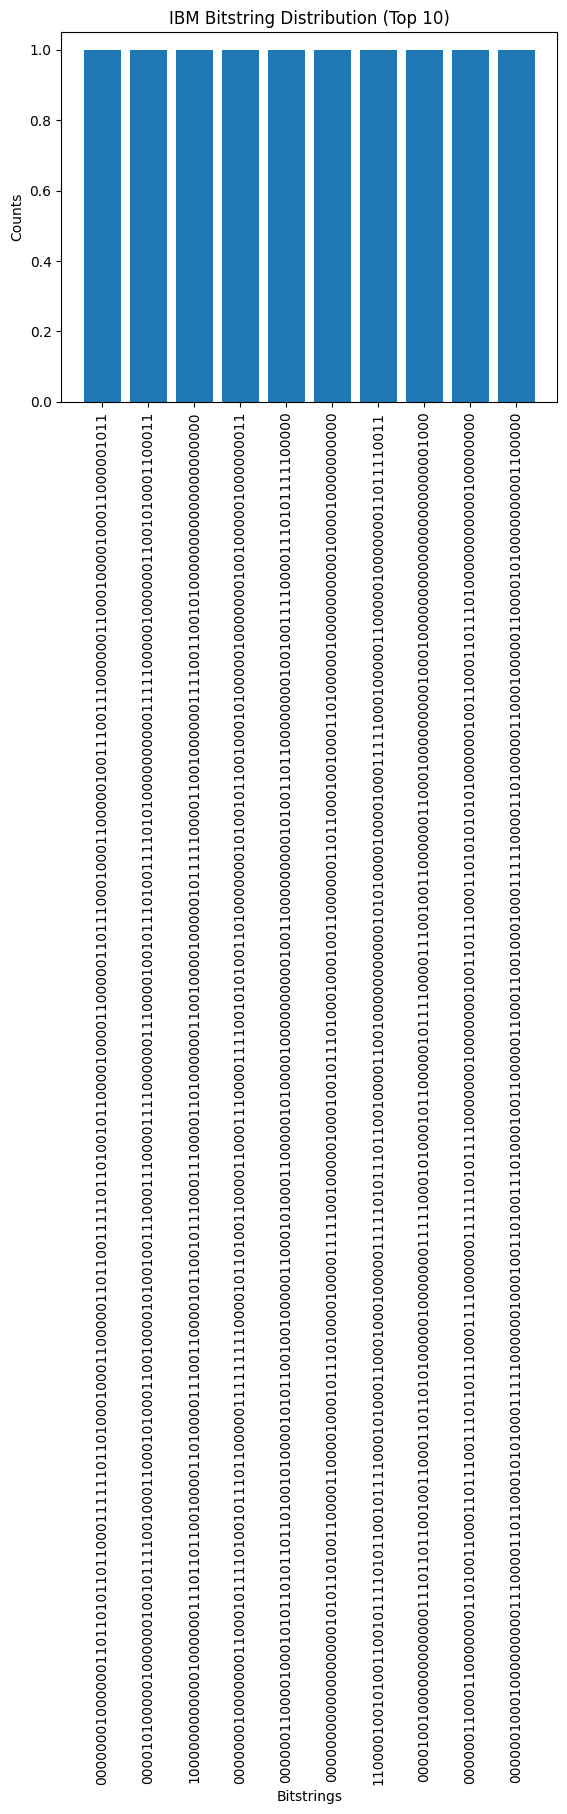

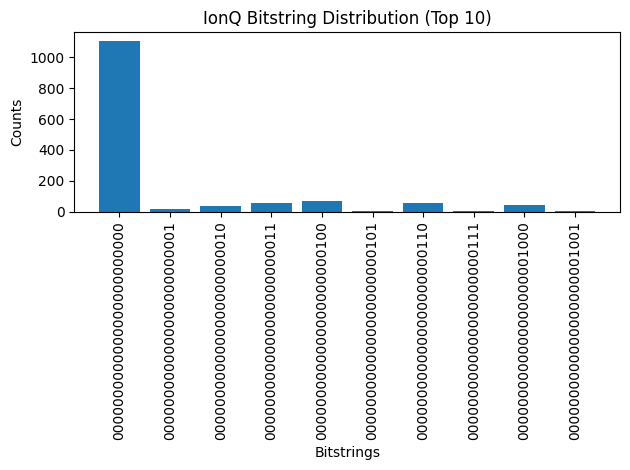

In [12]:
plot_bitstring_distribution(ibm_results[:10], "IBM Bitstring Distribution (Top 10)")
plot_bitstring_distribution(ionq_results[:10], "IonQ Bitstring Distribution (Top 10)")

100%|██████████| 5320/5320 [00:00<00:00, 7632.71it/s]


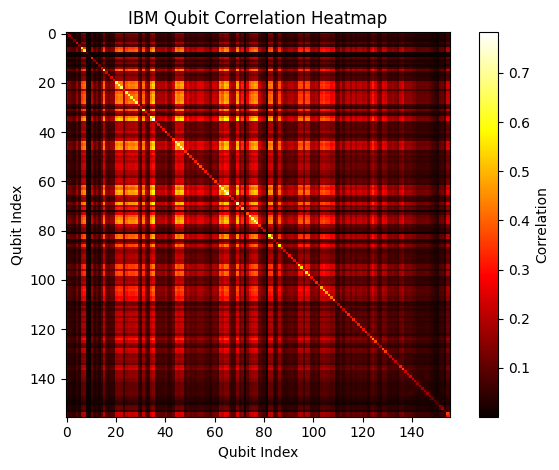

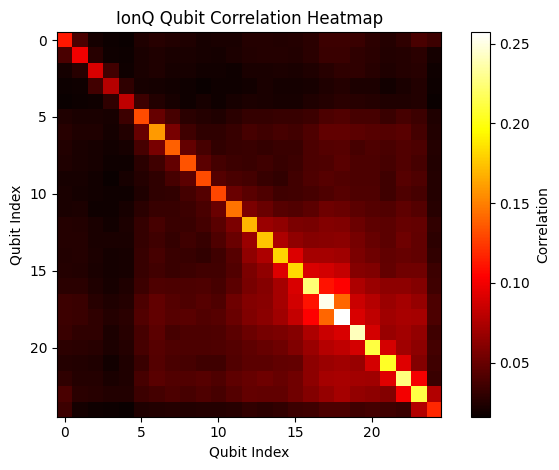

In [13]:
ibm_corr = compute_qubit_correlation(ibm_results, 156)
ionq_corr = compute_qubit_correlation(ionq_results, 25)
plot_qubit_correlation(ibm_corr, "IBM Qubit Correlation Heatmap")
plot_qubit_correlation(ionq_corr, "IonQ Qubit Correlation Heatmap")

In [14]:
ibm_entropy = compute_entropy(ibm_results)
ionq_entropy = compute_entropy(ionq_results)
print(f"IBM Entropy: {ibm_entropy}")
print(f"IonQ Entropy: {ionq_entropy}")

IBM Entropy: 13.28771237954811
IonQ Entropy: 10.62164241502984


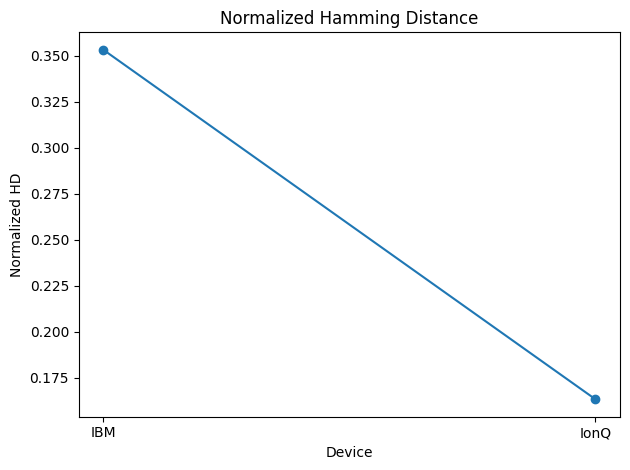

In [ ]:
ibm_normalized_hd = normalize_metric(ibm_hd, 156)
ionq_normalized_hd = normalize_metric(ionq_hd, 25)
plot_scaling(
    ["IBM", "IonQ"],
    [ibm_normalized_hd, ionq_normalized_hd],
    "Normalized Hamming Distance",
    "Device",
    "Normalized HD",
)

In [ ]:
import json
import numpy as np
import pandas as pd


# Function to analyze a single backend
def analyze_backend(backend_name, file_path, shots=10000):
    """
    Analyze a single quantum backend (IBM or IonQ) and compute relevant metrics.

    Parameters:
        backend_name (str): Name of the backend (e.g., "ibm_torino" or "ionq_aria-1").
        file_path (str): Path to the JSON file with backend data.
        shots (int): Number of shots for IBM simulation; IonQ results are pre-scaled.

    Returns:
        dict: Computed metrics including zero-state probability, average hamming distance,
              average error per qubit, and the number of qubits.
    """

    # Compute Zero-State Probability
    def compute_zero_probability(zeros, shots):
        return zeros / shots

    # Compute Average Hamming Distance
    def compute_hamming_distance(results, num_qubits):
        total_hd = 0
        total_counts = 0
        for bitstring, count in results:
            hd = sum(int(b) for b in bitstring)
            total_hd += hd * count
            total_counts += count
        return total_hd / total_counts

    # Compute Error per Qubit
    def compute_error_per_qubit(results, num_qubits):
        error_counts = [0] * num_qubits
        total_counts = 0
        for bitstring, count in results:
            for i, bit in enumerate(bitstring):
                if bit == "1":
                    error_counts[i] += count
            total_counts += count
        return [e / total_counts for e in error_counts]

    if backend_name.startswith("ibm_"):
        # IBM backend logic
        ibm_zeros = 0
        ibm_results = []
        with open(file_path, "r") as f:
            data = json.load(f)
            n_qubits = data["results"][0]["header"]["n_qubits"]
            for result, count in data["results"][0]["data"]["counts"].items():
                bin_str = bin(int(result, 16))[2:].zfill(n_qubits)
                ibm_results.append((bin_str, count))
                ibm_zeros += count * bin_str.count("0")
        zero_prob = compute_zero_probability(ibm_zeros, shots)
        hamming_distance = compute_hamming_distance(ibm_results, n_qubits)
        error_per_qubit = compute_error_per_qubit(ibm_results, n_qubits)

    elif backend_name.startswith("ionq_"):
        # IonQ backend logic
        ionq_zeros = 0
        ionq_results = []
        n_qubits = 25  # Fixed for IonQ
        with open(file_path, "r") as f:
            counts = json.load(f)
            for result, count in counts.items():
                bin_str = bin(int(result))[2:].zfill(n_qubits)
                ionq_results.append((bin_str, round(count * shots)))
                ionq_zeros += count * bin_str.count("0")
        zero_prob = ionq_zeros  # IonQ results are pre-scaled
        hamming_distance = compute_hamming_distance(ionq_results, n_qubits)
        error_per_qubit = compute_error_per_qubit(ionq_results, n_qubits)

    else:
        raise ValueError("Unsupported backend name. Must start with 'ibm_' or 'ionq_'.")

    avg_error_per_qubit = np.mean(error_per_qubit)

    return {
        "Backend Name": backend_name,
        "Zero-State Probability": zero_prob,
        "Average Hamming Distance": hamming_distance,
        "Average Error per Qubit": avg_error_per_qubit,
        "Number of Qubits": n_qubits,
    }


# List of IBM and IonQ files
ibm_files = [
    "data/ibm_fez.json",
    "data/ibm_torino.json",
    "data/ibm_brisbane.json",
    "data/ibm_brussels.json",
    "data/ibm_cusco.json",
    "data/ibm_kyiv.json",
    "data/ibm_nazca.json",
    "data/ibm_strasbourg.json",
    "data/ibm_sherbrooke.json",
]
ionq_file = "data/ionq_aria-1.json"

# Combine file paths and backend names
backends = [
    {"name": "ibm_fez", "file": ibm_files[0]},
    {"name": "ibm_torino", "file": ibm_files[1]},
    {"name": "ibm_brisbane", "file": ibm_files[2]},
    {"name": "ibm_brussels", "file": ibm_files[3]},
    {"name": "ibm_cusco", "file": ibm_files[4]},
    {"name": "ibm_kyiv", "file": ibm_files[5]},
    {"name": "ibm_nazca", "file": ibm_files[6]},
    {"name": "ibm_strasbourg", "file": ibm_files[7]},
    {"name": "ibm_sherbrooke", "file": ibm_files[8]},
    {"name": "ionq_aria-1", "file": ionq_file},
]

# Analyze all backends
all_metrics = []
for backend in backends:
    metrics = analyze_backend(backend["name"], backend["file"])
    all_metrics.append(metrics)

# Convert to a DataFrame for comparison
final_df = pd.DataFrame(all_metrics)

# Display the final DataFrame
final_df

,Backend Name,Zero-State Probability,Average Hamming Distance,Average Error per Qubit,Number of Qubits
0,ibm_fez,100.8969,55.1031,0.353225,156
1,ibm_torino,85.4306,47.5694,0.357665,133
2,ibm_brisbane,73.2812,53.7188,0.422983,127
3,ibm_brussels,74.1206,52.8794,0.416373,127
4,ibm_cusco,79.2240,47.7760,0.376189,127
5,ibm_kyiv,69.9129,57.0871,0.449505,127
6,ibm_nazca,74.6422,52.3578,0.412266,127
7,ibm_strasbourg,72.3428,54.6572,0.430372,127
8,ibm_sherbrooke,68.4177,58.5823,0.461278,127
9,ionq_aria-1,20.9151,4.0849,0.163396,25
